In [12]:
import sys
import time
print(sys.executable)
from utils import *
import matplotlib.ticker as plticker

/Users/clivian/opt/anaconda3/bin/python


In [2]:
# daily_ratings, movie_ratings = loadDic()
daily_ratings, movie_ratings = loadDic()

In [3]:
# mostPop(daily_ratings, 62423, sys.maxsize)

In [4]:
temp_mkeys = mostPop(daily_ratings, 20, (2019, 1, 1))
temp_mtitles = getMovieTitleById(temp_mkeys)

['Star Wars: Episode IV - A New Hope (1977)', 'Pulp Fiction (1994)', 'Shawshank Redemption, The (1994)', 'Forrest Gump (1994)', "Schindler's List (1993)", 'Silence of the Lambs, The (1991)', 'Godfather, The (1972)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', 'Matrix, The (1999)', 'American Beauty (1999)', 'Fight Club (1999)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Lord of the Rings: The Two Towers, The (2002)', 'Lord of the Rings: The Return of the King, The (2003)', 'Dark Knight, The (2008)', 'WALL·E (2008)', 'Up (2009)', 'Avatar (2009)', 'Inception (2010)']


In [5]:
temp_mkeys
time_dic = {
    2015:[(2014, 11), (2014, 12)] + ([(2015, m) for m in range(1, 11)]),
    2016:[(2015, 11), (2015, 12)] + ([(2016, m) for m in range(1, 11)]),
    2017:[(2016, 11), (2016, 12)] + ([(2017, m) for m in range(1, 11)]),
    2018:[(2017, 11), (2017, 12)] + ([(2018, m) for m in range(1, 11)]),
    2019:[(2018, 11), (2018, 12)] + ([(2019, m) for m in range(1, 11)])
}

In [6]:
def getRPrecision(params):
    delta_t_list = params['delta_t']
    day_aves = []
    for delta_t in delta_t_list:
        day_ave = {}
        for _year in range(2015, 2020):
            day_count = 0
            for year, month in time_dic[_year]:
                for day in range(1, 32):
                    date = (year, month, day)
                    if daily_ratings.get(date, -1) == -1:
                        print('date', date, 'invalid')
                        continue
                    day_count += 1
                    user_activities = getUserActivities(daily_ratings[date])
                    max_R = getMaxR(user_activities)
                    day_recentPop = day_decayPop = delta_t
                    
                    max_R_mostPop, max_R_recentPop, max_R_decayPop = (
                        mostPop(daily_ratings, max_R, date),
                        recentPop(daily_ratings, max_R, date, day_recentPop),
                        decayPop(daily_ratings, max_R, date, day_decayPop)
                    )

                    mostPop_cur, recentPop_cur, decayPop_cur = (
                        RPrecision(user_activities, max_R_mostPop),
                        RPrecision(user_activities, max_R_recentPop),
                        RPrecision(user_activities, max_R_decayPop)
                    )
                    
                    day_ave[date] = [mostPop_cur, recentPop_cur, decayPop_cur]
        day_aves.append(day_ave)
    return day_aves

In [11]:
start = time.time() 
params = {}
# params['delta_t'] = [1, 2]
params['delta_t'] = [1, 2, 4, 8, 16, 32]
day_aves = getRPrecision(params)
np.save(os.path.join('data', 'day_aves.npy'), day_aves)
end = time.time()
elapse = end - start
print(elapse)

date (2014, 11, 31) invalid


KeyboardInterrupt: 

In [17]:
day_aves = np.load(os.path.join('data', 'day_aves.npy'), allow_pickle=True).tolist()
month_aves = []
year_aves = []
weekday_pattern = []
monthly_pattern = []
yearly_pattern = []
for method in range(0, 3):
    year_ave_per_method = []
    month_ave_per_method = []
    weekday_pattern_per_method = [[] for i in range(7)]
    monthly_pattern_per_method = [[] for i in range(12)]
    yearly_pattern_per_method = [[] for i in range(5)]
    for day_ave in day_aves:
        year_ave_per_param = []
        month_ave_per_param = []
        for _year in range(2015, 2020):
            year_value = []
            for year, month in time_dic[_year]:
                month_value = []
                for day in range(1, 32):
                    value = day_ave.get((year, month, day), -1)
                    if value != -1:
                        month_value.append(value[method])
                        year_value.append(value[method])
                        if day_ave == day_aves[2]: # deltat = 4
                            weekday = date(year, month, day).weekday()
                            weekday_pattern_per_method[weekday].append(value[method])
                            monthly_pattern_per_method[month - 1].append(value[method])
                            yearly_pattern_per_method[year - 2015].append(value[method])
                month_ave_per_param.append(sum(month_value) / len(month_value) * 100)
            year_ave_per_param.append("%.3f" % (sum(year_value) / len(year_value) * 100))
        year_ave_per_method.append(year_ave_per_param)
        month_ave_per_method.append(month_ave_per_param)
    year_aves.append(year_ave_per_method)
    month_aves.append(month_ave_per_method)
    weekday_pattern.append([(sum(v) / len(v) * 100) for v in weekday_pattern_per_method])
    monthly_pattern.append([(sum(v) / len(v) * 100) for v in monthly_pattern_per_method])
    yearly_pattern.append([(sum(v) / len(v) * 100) for v in yearly_pattern_per_method])
methods = ['mostPop', 'recentPop', 'decayPop']
colors = ['r', 'b', 'g', 'c', 'm', 'y']

In [58]:
yearly_count = [0] * 5
monthly_count = [0] * 12
weekday_count = [0] * 7
yearly_new_movie = [0] * 5
monthly_new_movie = [0] * 12
weekday_new_movie = [0] * 7
existing_movie = set()
for rating in daily_ratings:
    year = rating[0]
    if year < 2015:
        continue
    month = rating[1]
    day = rating[2]
    weekday = date(year, month, day).weekday()
    new_movie_count = 0
    for movie in daily_ratings[rating]:
        yearly_count[year - 2015] += len(daily_ratings[rating][movie])
        monthly_count[month - 1] += len(daily_ratings[rating][movie])
        weekday_count[weekday] += len(daily_ratings[rating][movie])
        if movie not in existing_movie:
            existing_movie.add(movie)
            new_movie_count += 1
    yearly_new_movie[year - 2015] += new_movie_count
    monthly_new_movie[month - 1] += new_movie_count
    weekday_new_movie[weekday] += new_movie_count
            
print(sum(yearly_count))
print(sum(monthly_count))
print(sum(weekday_count))
print(sum(yearly_new_movie))
print(sum(monthly_new_movie))
print(sum(weekday_new_movie))
print(yearly_count)
print(monthly_count)
print(weekday_count)
print(yearly_new_movie)
print(monthly_new_movie)
print(weekday_new_movie)

7497002
7497002
7497002
57801
57801
57801
[1604061, 1756856, 1690321, 1310712, 1135052]
[691612, 604051, 643229, 582075, 677054, 548120, 665809, 672548, 630118, 626252, 604990, 551144]
[1244250, 1021458, 989868, 937774, 901617, 1115658, 1286377]
[10478, 11098, 12088, 8874, 15263]
[6230, 5673, 3844, 2943, 4869, 3988, 3586, 7358, 5584, 4736, 3959, 5031]
[7240, 8525, 7786, 7745, 4861, 9683, 11961]


<ipython-input-18-905d7c48485c>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(year_x)


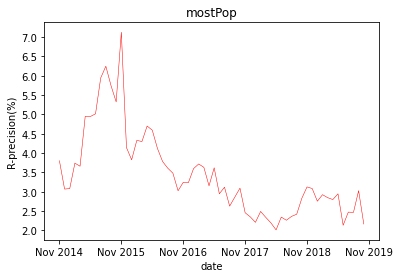

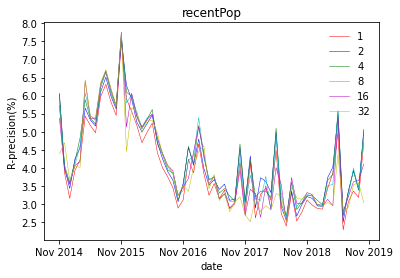

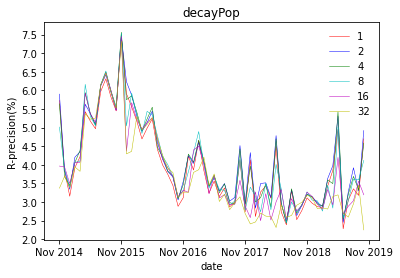

In [18]:
# plot monthly average
year_x = ['']
for year in range(2014, 2020):
    year_x.append('Nov ' + str(year))
year_x[0] = 'Nov 2014'
temp_x = [i for i in range(0, 60)]
for i in range(0, len(methods)):
    fig, ax = plt.subplots()
    x_loc = plticker.MultipleLocator(base=12)
    y_loc = plticker.MultipleLocator(base=0.5)
    ax.xaxis.set_major_locator(x_loc)
    ax.yaxis.set_major_locator(y_loc)
    ax.set_title(str(methods[i]), loc='center')
    if methods[i] == 'mostPop':
        param = params['delta_t'][0]
        ax.plot(temp_x, month_aves[i][0], color=colors[0], linewidth=0.5)
    else:
        for j in range(0, len(params['delta_t'])):
            param = params['delta_t'][j]
            ax.plot(temp_x, month_aves[i][j], color=colors[j], linewidth=0.5, label=str(param))
        ax.legend(loc='upper right', frameon=False)
    ax.set_xticklabels(year_x)
    ax.set_xlabel('date')
    ax.set_ylabel('R-precision(%)' )
    fig.savefig('./figures/monthly_average_' + str(methods[i]), bbox_inches='tight', dpi=300)

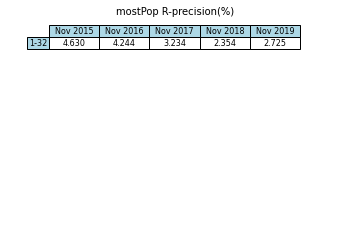

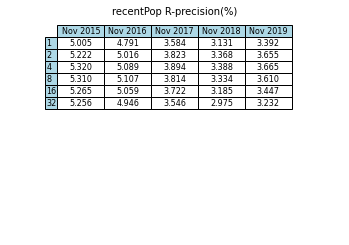

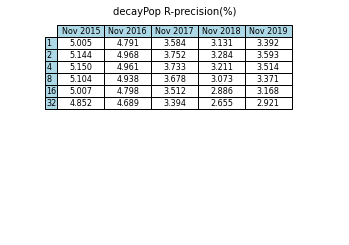

In [35]:
# plot yearly average
for i in range(0, len(methods)):
    fig, ax = plt.subplots() 
    ax.set_axis_off() 
    ax.set_title(str(methods[i]) + ' R-precision(%)', loc='center', fontsize=10)
    if methods[i] == 'mostPop':        
        table = ax.table(
            cellText = [year_aves[i][0]],
            colLabels = ['Nov ' + str(year) for year in range(2015, 2021)],
            rowLabels = ['1-32'],
            rowColours = ["lightblue"] * 1,  
            colColours = ["lightblue"] * len(year_aves[i][0]), 
            colWidths = [0.15] * len(year_aves[i][0]),
            cellLoc = 'center',
            loc = 'upper center',
        )
    else:
        table = ax.table(
            cellText = year_aves[i],
            rowLabels = params['delta_t'],
            colLabels = ['Nov ' + str(year) for year in range(2015, 2021)],
            rowColours = ["lightblue"] * len(year_aves[i]),  
            colColours = ["lightblue"] * len(year_aves[i][0]), 
            colWidths= [0.14] * len(year_aves[i][0]),
            cellLoc ='center',
            loc ='upper center',
        )
    bbox = table.get_window_extent(fig.canvas.get_renderer())
    bbox = bbox.from_extents(bbox.xmin-5, bbox.ymin-5, bbox.xmax+5, bbox.ymax+25)
    bbox_inches = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('./figures/yearly_average_' + str(methods[i]), bbox_inches=bbox_inches, dpi=300)
    

<ipython-input-55-c04abb18f580>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.', 'Sun.'])
<ipython-input-55-c04abb18f580>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.', 'Sun.'])
<ipython-input-55-c04abb18f580>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.', 'Sun.'])


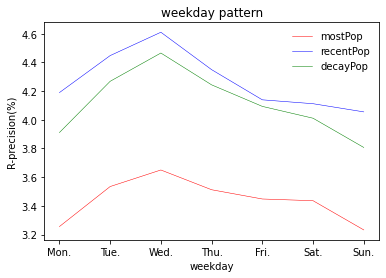

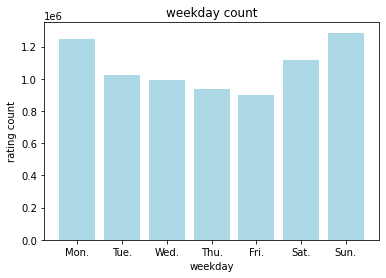

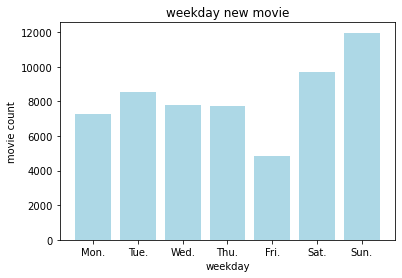

In [55]:
# weekday_pattern
fig, ax = plt.subplots()
temp_x = [i for i in range(7)]
x_loc = plticker.MultipleLocator(base=1)
y_loc = plticker.MultipleLocator(base=0.2)
ax.xaxis.set_major_locator(x_loc)
ax.yaxis.set_major_locator(y_loc)
ax.set_title('weekday pattern', loc='center')
for i in range(3):
    ax.plot(temp_x,
            weekday_pattern[i],
            color=colors[i], linewidth=0.5, label = methods[i])
ax.set_xticklabels(['', 'Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.', 'Sun.'])
ax.legend(loc='upper right', frameon=False)
ax.set_xlabel('weekday')
ax.set_ylabel('R-precision(%)')
fig.savefig('./figures/weekday_pattern', bbox_inches='tight', dpi=300)

fig, ax = plt.subplots()
ax.set_title('weekday count', loc='center')
ax.bar(temp_x, weekday_count, color='lightblue')
ax.set_xticklabels(['', 'Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.', 'Sun.'])
ax.set_xlabel('weekday')
ax.set_ylabel('rating count')
fig.savefig('./figures/weekday_count', bbox_inches='tight', dpi=300)

fig, ax = plt.subplots()
ax.set_title('weekday new movie', loc='center')
ax.bar(temp_x, weekday_new_movie, color='lightblue')
ax.set_xticklabels(['', 'Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.', 'Sun.'])
ax.set_xlabel('weekday')
ax.set_ylabel('movie count')
fig.savefig('./figures/weekday_new_movie', bbox_inches='tight', dpi=300)

<ipython-input-56-927840e49acc>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
<ipython-input-56-927840e49acc>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
<ipython-input-56-927840e49acc>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',


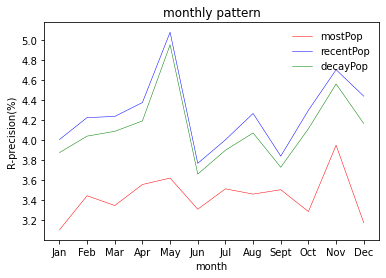

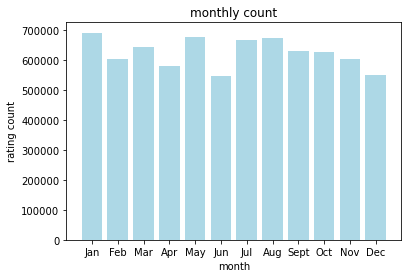

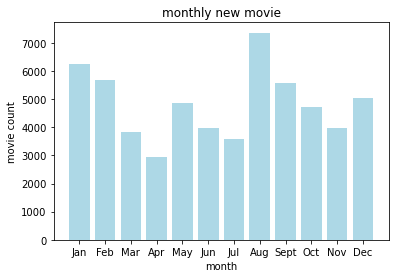

In [56]:
# monthly_pattern
fig, ax = plt.subplots()
temp_x = [i for i in range(12)]
x_loc = plticker.MultipleLocator(base=1)
y_loc = plticker.MultipleLocator(base=0.2)
ax.xaxis.set_major_locator(x_loc)
ax.yaxis.set_major_locator(y_loc)
ax.set_title('monthly pattern', loc='center')
for i in range(3):
    ax.plot(temp_x,
            monthly_pattern[i],
            color=colors[i], linewidth=0.5, label = methods[i])
ax.set_xticklabels(['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
                    'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
ax.legend(loc='upper right', frameon=False)
ax.set_xlabel('month')
ax.set_ylabel('R-precision(%)' )
fig.savefig('./figures/monthly_pattern', bbox_inches='tight', dpi=300)

fig, ax = plt.subplots()
ax.set_title('monthly count', loc='center')
x_loc = plticker.MultipleLocator(base=1)
ax.xaxis.set_major_locator(x_loc)
ax.bar(temp_x, monthly_count, color='lightblue')
ax.set_xticklabels(['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
                    'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel('month')
ax.set_ylabel('rating count')
fig.savefig('./figures/monthly_count', bbox_inches='tight', dpi=300)

fig, ax = plt.subplots()
ax.set_title('monthly new movie', loc='center')
x_loc = plticker.MultipleLocator(base=1)
ax.xaxis.set_major_locator(x_loc)
ax.bar(temp_x, monthly_new_movie, color='lightblue')
ax.set_xticklabels(['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
                    'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel('month')
ax.set_ylabel('movie count')
fig.savefig('./figures/monthly_new_movie', bbox_inches='tight', dpi=300)

<ipython-input-57-389e532ab5aa>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '2015', '2016', '2017', '2018', '2019'])
<ipython-input-57-389e532ab5aa>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '2015', '2016', '2017', '2018', '2019'])
<ipython-input-57-389e532ab5aa>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '2015', '2016', '2017', '2018', '2019'])


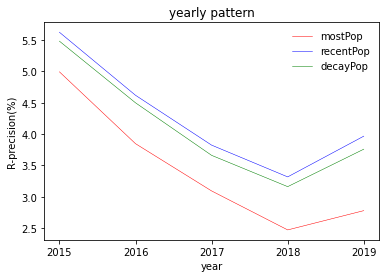

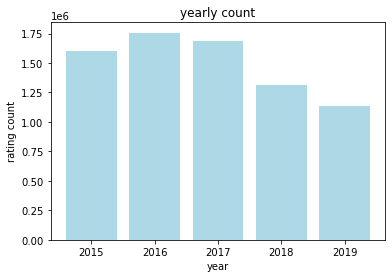

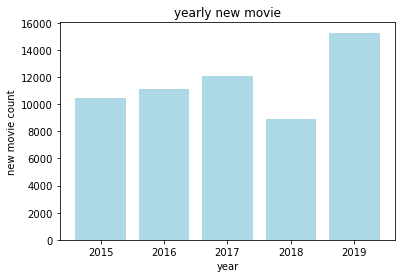

In [57]:
# yearly_pattern
fig, ax = plt.subplots()
temp_x = [i for i in range(5)]
x_loc = plticker.MultipleLocator(base=1)
y_loc = plticker.MultipleLocator(base=0.5)
ax.xaxis.set_major_locator(x_loc)
ax.yaxis.set_major_locator(y_loc)
ax.set_title('yearly pattern', loc='center')
for i in range(3):
    ax.plot(temp_x,
            yearly_pattern[i],
            color=colors[i], linewidth=0.5, label = methods[i])
ax.set_xticklabels(['', '2015', '2016', '2017', '2018', '2019'])
ax.legend(loc='upper right', frameon=False)
ax.set_xlabel('year')
ax.set_ylabel('R-precision(%)' )
fig.savefig('./figures/yearly_pattern', bbox_inches='tight', dpi=300)

fig, ax = plt.subplots()
ax.set_title('yearly count', loc='center')
ax.bar(temp_x, yearly_count, color='lightblue')
ax.set_xticklabels(['', '2015', '2016', '2017', '2018', '2019'])
ax.set_xlabel('year')
ax.set_ylabel('rating count')
fig.savefig('./figures/yearly_count', bbox_inches='tight', dpi=300)

fig, ax = plt.subplots()
ax.set_title('yearly new movie', loc='center')
ax.bar(temp_x, yearly_new_movie, color='lightblue')
ax.set_xticklabels(['', '2015', '2016', '2017', '2018', '2019'])
ax.set_xlabel('year')
ax.set_ylabel('new movie count')
fig.savefig('./figures/yearly_new_movie', bbox_inches='tight', dpi=300)

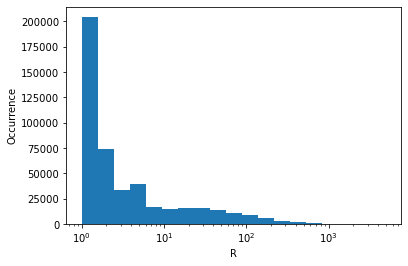

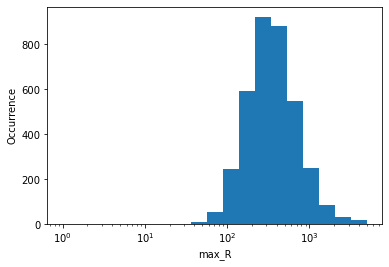

In [61]:
R_list = []
for _year in range(2015, 2020):
            for year, month in time_dic[_year]:
                for day in range(1, 32):
                    date = (year, month, day)
                    if daily_ratings.get(date, -1) == -1:
                        continue
                    user_activities = getUserActivities(daily_ratings[date])
                    for user in user_activities:
                        movies = user_activities[user]
                        R_list.append(len(movies))
fig, ax = plt.subplots()
ax.hist(R_list, bins=np.logspace(np.log10(1),np.log10(5000), 20))
plt.xscale('log')
ax.set_xlabel('R')
ax.set_ylabel('Occurrence' )
fig.savefig('./figures/R_pattern', bbox_inches='tight', dpi=300)

max_R_path = os.path.join('data', 'max_R_dic.npy')
max_R_dic = np.load(max_R_path, allow_pickle=True).item()
R_list = []
for day in max_R_dic:
    R_list.append(max_R_dic[day])
fig, ax = plt.subplots()
ax.hist(R_list, bins=np.logspace(np.log10(1),np.log10(5000), 20))
plt.xscale('log')
ax.set_xlabel('max_R')
ax.set_ylabel('Occurrence' )
fig.savefig('./figures/max_R_pattern', bbox_inches='tight', dpi=300)

In [63]:
yearly_count = [0] * 11
monthly_count = [0] * 12
weekday_count = [0] * 7
yearly_new_movie = [0] * 11
monthly_new_movie = [0] * 12
weekday_new_movie = [0] * 7
existing_movie = set()
for rating in daily_ratings:
    year = rating[0]
    month = rating[1]
    day = rating[2]
    weekday = date(year, month, day).weekday()
    new_movie_count = 0
    for movie in daily_ratings[rating]:
        yearly_count[year - 2009] += len(daily_ratings[rating][movie])
        monthly_count[month - 1] += len(daily_ratings[rating][movie])
        weekday_count[weekday] += len(daily_ratings[rating][movie])
        if movie not in existing_movie:
            existing_movie.add(movie)
            new_movie_count += 1
    yearly_new_movie[year - 2009] += new_movie_count
    monthly_new_movie[month - 1] += new_movie_count
    weekday_new_movie[weekday] += new_movie_count
print(yearly_count)
print(monthly_count)
print(weekday_count)
print(yearly_new_movie)
print(monthly_new_movie)
print(weekday_new_movie)

[112555, 792767, 676488, 634829, 516094, 478141, 1604061, 1756856, 1690321, 1310712, 1135052]
[978469, 853548, 903323, 840619, 953613, 783856, 916025, 916725, 890926, 864917, 927131, 878724]
[1772331, 1486715, 1403679, 1349875, 1304275, 1562989, 1828012]
[294, 4003, 1770, 751, 458, 899, 8179, 9036, 10653, 8121, 14430]
[5858, 5890, 3800, 3114, 4589, 3836, 5238, 7220, 5503, 4252, 4094, 5200]
[7512, 8817, 8174, 8300, 5413, 9143, 11235]
